In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib
import os        
from config import root
import re
from scipy import stats
from nipype.interfaces import fsl

# import custom libraries
from tools.glm import (add_regressors, array2dummies,
                       n_back_array, n_back_series,
                       glm, contrast)

root

'/data/ext/PhD/Studies/PrimingDecay'

In [2]:
def pearsonr(X, Y):
    
    # Assuming last dimension is time
    X = X.T
    Y = Y.T

    # Pearson r
    cov = np.sum((X - np.mean(X, axis=0)) * (Y - np.mean(Y, axis=0)), axis=0)
    std = np.sum((X - np.mean(X, axis=0))**2, axis=0)**.5 * np.sum((Y - np.mean(Y, axis=0))**2, axis=0)**.5

    del X
    del Y
    
    return cov / std

In [3]:
def create_yhat(pes, mats):
    
    yhat = np.zeros(pes[0].shape + (len(mats),))
    for i, pe in enumerate(pes):
        yhat += np.tile(np.reshape(pe, pes[0].shape + (1,)), len(mats)) * mats[mats.columns[i]].values
    
    del pes
    del mats
    
    return yhat

In [12]:
subdir = "_sub_id_sub_{sub_id}"
featmodel = "pop_decay_featmodel_ses1/mapflow"
mat_runfname = "_pop_decay_featmodel_ses1{run}/run{run}.mat"

all_paths = pd.DataFrame()

for sub in range(1, 7):    
    featmodel_subdir = os.path.join(
        root, "data", "working_dir", 
        "glm/pop_decay_firstlevel", 
        subdir.format(sub_id="%03d" % sub),
        featmodel)

    # Mat files
    mat_paths = []
    for i, run in enumerate(os.listdir(featmodel_subdir)):
        mat_path = os.path.join(featmodel_subdir, mat_runfname.format(run=i))
        mat_paths.append(mat_path)
        if not os.path.exists(mat_path):
            print("WARNING MAT DOES NOT EXIST")
    
    # PE files
    pe_subdir = os.path.join(
        root, "data", "output", 
        "pop_decay_filmgls",
        "sub_%03d" % sub
    )
    
    pe_paths = []
    for i, run in enumerate(os.listdir(pe_subdir)):
        pe_path = os.path.join(pe_subdir, "_pop_decay_filmgls{run}".format(run=i))
        pe_paths.append(pe_path)
        if not os.path.exists(pe_path):
            print("WARNING PE DOES NOT EXIST")
        
    # Sort timeseries files
    ts_path = os.path.join(root, "data", "output", "highpass")
    sessions = sorted(re.findall("^ses_00[0-8]sub_%03d$" % sub, "\n".join(os.listdir(ts_path)), re.M))
    ts_paths = []
    ses_scn = []
    for i, ses in enumerate(sessions):
        runs = os.listdir(os.path.join(ts_path, ses))
        for j, run in enumerate(runs):
            ts_fname = os.path.join(
                ts_path, ses, run, "run_%03d_st_mcf_warp_dtype_bet_intnorm_smooth_hpf.nii.gz" % j
            )
            ses_scn.append((i, j))
            ts_paths.append(ts_fname)
            if not os.path.exists(ts_fname):
                print("WARNING TS DOES NOT EXIST")
    
    ses, scn = zip(*ses_scn)
    all_paths = all_paths.append(pd.DataFrame({
        "sub" : sub,
        "ses" : ses,
        "scn" : scn,
        "run" : range(len(mat_paths)),
        "mat" : mat_paths,
        "pe": pe_paths,
        "ts": ts_paths,
    }), ignore_index=True)

In [ ]:
for run in all_paths.index:
    pe_path = all_paths.loc[run, "pe"]
    ts_path = all_paths.loc[run, "ts"]
    mat_path = all_paths.loc[run, "mat"]
    r2_path = os.path.join(root, "data", "output", "postprocessing", "partialrsquared")
    r2_path_sub = os.path.join(r2_path, "%03d" % all_paths.loc[run, "sub"])
        
    if not os.path.exists(r2_path):
        os.mkdir(r2_path)
    if not os.path.exists(r2_path_sub):
        os.mkdir(r2_path_sub)
        
    mat_file = pd.read_csv(
        mat_path,
        skiprows=5, 
        header=None, 
        sep="\t", 
        usecols=list(range(16))[0::2]
    )
    
    print("Get TS data")
    ts = nib.load(ts_path)
    ts_data = ts.get_data()
    
    # Remove baseline
    regs = mat_file.columns[:4].tolist()
    mats = mat_file[regs]
    pes = []
    print("Load regs")
    for reg in regs:
        pe = nib.load(
            os.path.join(
                pe_path,
                "pe%d.nii.gz" % (int(reg) + 1)
            ))
        pes.append(pe.get_data())
        
    print("Create baseline")
    baseline = create_yhat(pes, mats)
    res = ts_data - baseline
    del baseline
    del ts_data
    
    # Look at regs of interest
    print("Load regs")
    regs = mat_file.columns[4:].tolist()
    for reg in regs:
        print("- doing", reg)
        other = regs.copy()
        other.remove(reg)
        opes = []
        for o in other:
            pe = nib.load(
                os.path.join(
                    pe_path, 
                    "pe%d.nii.gz" % (int(o) + 1)
                ))
            opes.append(pe.get_data())

        yhat_res = create_yhat(opes, mat_file[other])
        yhat_reg = create_yhat(
            [nib.load(
                os.path.join(pe_path, "pe%d.nii.gz" % (int(reg) +1))
            ).get_data()], 
            mat_file[[reg]])
        
        R = pearsonr(res - yhat_res, yhat_reg)
        R2 = R**2
        
        imgR2 = nib.Nifti1Image(R2.T, pe.affine)
        
        r2_path_run = os.path.join(r2_path_sub, "pe"+str(reg)+"_"+"run_%d.nii.gz" % all_paths.loc[run, "run"])
        nib.save(imgR2, r2_path_run)
        
    del yhat_res
    del yhat_reg

In [6]:
regs = [8, 10, 12, 14]
postprocessing = os.path.join(root, "data", "output", "postprocessing")

In [7]:
# # correct axes
# for run in all_paths.index:
#     pe_path = all_paths.loc[run, "pe"]
#     r2_path = os.path.join(postprocessing, "partialrsquared", "%03d" % all_paths.loc[run, "sub"])
#     r2_new_path = os.path.join(postprocessing, "partialrsquared_corr")
    
#     if not os.path.exists(r2_new_path):
#         os.mkdir(r2_new_path)
        
#     r2_new_path_subdir = os.path.join(r2_new_path, "%03d" % all_paths.loc[run, "sub"])

#     if not os.path.exists(r2_new_path_subdir):
#         os.mkdir(r2_new_path_subdir)
        
#     for reg in regs:     
#         fname = "pe%d_run_%d.nii.gz" 
#         r2_path_run = os.path.join(r2_path, fname % (reg, all_paths.loc[run, "run"]))
#         r2_new_path_run = os.path.join(r2_new_path_subdir, fname % (reg+1, all_paths.loc[run, "run"]))
#         r2 = nib.load(r2_path_run)
#         r2_data = r2.get_data().T
        
#         pe_path_run = os.path.join(pe_path, "pe%d.nii.gz" % (int(reg) + 1))
#         pe = nib.load(pe_path_run)
        
#         imgR2 = nib.Nifti1Image(r2_data, pe.affine)
#         nib.save(imgR2, r2_new_path_run)

In [8]:
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
mni_brain_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")

In [ ]:
# warp to mni
for run in all_paths.index:
    sub = all_paths.loc[run, "sub"]
    pe_path = all_paths.loc[run, "pe"]
    r2_path = os.path.join(postprocessing, "partialrsquared_corr", "%03d" % sub)
    for reg in regs:
        r2_path_run = os.path.join(r2_path, "pe%d_run_%d.nii.gz" % (reg+1, all_paths.loc[run, "run"]))
        pe_path_run = os.path.join(pe_path, "pe%d.nii.gz" % (reg+1))

        r2_path_run_warped = os.path.join(r2_path, "warped_pe%d_run_%d.nii.gz" % (reg, all_paths.loc[run, "run"]))
        pe_path_run_warped = os.path.join(pe_path, "warped_pe%d.nii.gz" % (int(reg) + 1))

        warp_r2 = fsl.ApplyWarp(
            in_file=r2_path_run,
            out_file=r2_path_run_warped,
            ref_file=mni_brain_standard_path,
            field_file=os.path.join(root, "data", "output", "register_to_standard", "sub_%03d" % sub, "orig_field.nii.gz"),
            premat=os.path.join(root, "data", "output", "register_to_standard", "sub_%03d" % sub, "inplane_brain_bbreg_sub_%03d.mat" % sub),
        )
        
        warp_pe = fsl.ApplyWarp(
            in_file=pe_path_run,
            out_file=pe_path_run_warped,
            ref_file=mni_brain_standard_path,
            field_file=os.path.join(root, "data", "output", "register_to_standard", "sub_%03d" % sub, "orig_field.nii.gz"),
            premat=os.path.join(root, "data", "output", "register_to_standard", "sub_%03d" % sub, "inplane_brain_bbreg_sub_%03d.mat" % sub),
        )
        
        print(sub, run)
        warp_r2.run()
        warp_pe.run()                                   

In [9]:
clr1_rois_path = os.path.join(postprocessing, "clr1_replication.nii.gz")
clr2_rois_path = os.path.join(postprocessing, "clr2_replication.nii.gz")
loc1_rois_path = os.path.join(postprocessing, "loc1_replication.nii.gz")
loc2_rois_path = os.path.join(postprocessing, "loc2_replication.nii.gz")

In [9]:
clr1_rois_path = os.path.join(postprocessing, "clr1_replication_peak_rois.nii.gz")
clr2_rois_path = os.path.join(postprocessing, "clr2_replication_peak_rois.nii.gz")
loc1_rois_path = os.path.join(postprocessing, "loc1_replication_peak_rois.nii.gz")
loc2_rois_path = os.path.join(postprocessing, "loc2_replication_peak_rois.nii.gz")

In [10]:
clr1_rois = nib.load(clr1_rois_path).get_data()
clr2_rois = nib.load(clr2_rois_path).get_data()
loc1_rois = nib.load(loc1_rois_path).get_data()
loc2_rois = nib.load(loc2_rois_path).get_data()

In [13]:
# PE
rois_df = pd.DataFrame()
for run in all_paths.index:
    sub = all_paths.loc[run, "sub"]
    pe_path = all_paths.loc[run, "pe"]
    
    # loc1
    pe9 = nib.load(os.path.join(pe_path, "warped_pe9.nii.gz")).get_data()
    pe9_vals = []
    for i in range(1, int(loc1_rois.max())+1):
        mask = loc1_rois == i
        val = pe9[mask].mean()
        pe9_vals.append(val)
        
    # loc2
    pe11 = nib.load(os.path.join(pe_path, "warped_pe11.nii.gz")).get_data()
    pe11_vals = []
    for i in range(1, int(loc2_rois.max())+1):
        mask = loc2_rois == i
        val = pe11[mask].mean()
        pe11_vals.append(val)
        
    # clr1
    pe13 = nib.load(os.path.join(pe_path, "warped_pe13.nii.gz")).get_data()
    pe13_vals = []
    for i in range(1, int(clr1_rois.max())+1):
        mask = clr1_rois == i
        val = pe13[mask].mean()
        pe13_vals.append(val)

    # clr2
    pe15 = nib.load(os.path.join(pe_path, "warped_pe15.nii.gz")).get_data()
    pe15_vals = []
    for i in range(1, int(clr2_rois.max())+1):
        mask = clr2_rois == i
        val = pe15[mask].mean()
        pe15_vals.append(val)
        
    cols = ["pe_loc1_roi%d" % i for i in range(len(pe9_vals))]
    cols += ["pe_loc2_roi%d" % i for i in range(len(pe11_vals))]
    cols += ["pe_clr1_roi%d" % i for i in range(len(pe13_vals))]
    cols += ["pe_clr2_roi%d" % i for i in range(len(pe15_vals))]
    
    df = pd.DataFrame([
        pe9_vals + pe11_vals + pe13_vals + pe15_vals
    ], columns=cols)
    
    df = df.assign(**{
        "sub": sub,
        "ses": all_paths.loc[run, "ses"],
        "scn": all_paths.loc[run, "scn"]
    })
    
    rois_df = rois_df.append(df)

rois_df.to_csv("../data/pe_per_roi_per_contrast.csv", index=False)

In [14]:
# R2
r2_rois_df = pd.DataFrame()
for run in all_paths.index:
    sub = all_paths.loc[run, "sub"]
    r2_path = os.path.join(postprocessing, "partialrsquared_corr", "%03d" % sub)
    
    # loc1
    r2pe9 = nib.load(os.path.join(r2_path, "warped_pe8_run_%d.nii.gz" % (all_paths.loc[run, "run"]))).get_data()
    r2pe9_vals = []
    for i in range(1, int(loc1_rois.max())+1):
        mask = loc1_rois == i
        val = r2pe9[mask].mean()
        r2pe9_vals.append(val)
        
    # loc2
    r2pe11 = nib.load(os.path.join(r2_path, "warped_pe10_run_%d.nii.gz" % (all_paths.loc[run, "run"]))).get_data()
    r2pe11_vals = []
    for i in range(1, int(loc2_rois.max())+1):
        mask = loc2_rois == i
        val = r2pe11[mask].mean()
        r2pe11_vals.append(val)
        
    # clr1
    r2pe13 = nib.load(os.path.join(r2_path, "warped_pe12_run_%d.nii.gz" % (all_paths.loc[run, "run"]))).get_data()
    r2pe13_vals = []
    for i in range(1, int(clr1_rois.max())+1):
        mask = clr1_rois == i
        val = r2pe13[mask].mean()
        r2pe13_vals.append(val)
        
    # clr2
    r2pe15 = nib.load(os.path.join(r2_path, "warped_pe14_run_%d.nii.gz" % (all_paths.loc[run, "run"]))).get_data()
    r2pe15_vals = []
    for i in range(1, int(clr2_rois.max())+1):
        mask = clr2_rois == i
        val = r2pe15[mask].mean()
        r2pe15_vals.append(val)
        
    cols = ["r2_loc1_roi%d" % i for i in range(len(r2pe9_vals))]
    cols += ["r2_loc2_roi%d" % i for i in range(len(r2pe11_vals))]
    cols += ["r2_clr1_roi%d" % i for i in range(len(r2pe13_vals))]
    cols += ["r2_clr2_roi%d" % i for i in range(len(r2pe15_vals))]
    
    df = pd.DataFrame([
        r2pe9_vals + r2pe11_vals + r2pe13_vals + r2pe15_vals
    ], columns=cols)
    
    df = df.assign(**{
        "sub": sub,
        "ses": all_paths.loc[run, "ses"],
        "scn": all_paths.loc[run, "scn"]
    })
    
    r2_rois_df = r2_rois_df.append(df)
    
r2_rois_df.to_csv("../data/r2_per_roi_per_contrast.csv", index=False)

In [15]:
df = pd.read_csv("../data/regs_and_rts.csv")

pes = pd.DataFrame()

for (sub, ses, scn), group in df.groupby(["sub", "real_ses", "scn"], as_index=False):
    X = group[["loc1", "loc2", "loc3", "loc4", "lag1_loc", "lag2_loc", "lag1_clr", "lag2_clr"]].astype(float)
    Y = group.norm_rt
    b = glm(Y, X.T)
    
    b[:4] * group[["loc1", "loc2", "loc3", "loc4"]]
    
    baseline = (b[:4] * group[["loc1", "loc2", "loc3", "loc4"]]).sum(axis=1)
    res = Y - baseline
    
    regs = X.columns.tolist()[4:]
    
    rs = []
    for i, reg in enumerate(regs):
        other = regs.copy()
        other.remove(reg)
        
        # Make use of b[i] corresponding to regs[i]
        b_res = list(b[4:])
        b_reg = b_res.pop(i)
        
        yhat_res = (b_res * group[other]).sum(axis=1)
        yhat_reg = (b_reg * group[reg])

        r, p = stats.pearsonr(res - yhat_res, yhat_reg)
        rs.append(r**2)
    
    result = pd.DataFrame([b], columns=["loc1", "loc2", "loc3", "loc4", "rt_lag1_loc_pe", "rt_lag2_loc_pe", "rt_lag1_clr_pe", "rt_lag2_clr_pe"])
    result = result.join(pd.DataFrame([rs], columns=[reg+"_r" for reg in regs]))
    result = result.assign(**{
        "sub": sub,
        "ses": ses,
        "scn": scn,        
    })
    
    pes = pes.append(result)

In [16]:
joined = pes.set_index(["sub","ses","scn"]).join(r2_rois_df.set_index(["sub", "ses", "scn"])).join(rois_df.set_index(["sub", "ses", "scn"]))

In [17]:
joined.to_csv("../data/joined.csv", index=True)

In [18]:
for sub, group in joined.groupby("sub"):
#     print(sub)
    r, p = stats.pearsonr(group.pe_loc2_roi0, group.rt_lag2_loc_pe)
    print(r, p)

0.25598083516407705 0.180141046597512
0.3171217435148305 0.24944748276370562
0.02824631453725451 0.8910529317946888
0.39128432657589846 0.09760060783099773
0.5324512493092682 0.004249029935939507
0.19665757720606195 0.5196077648087751


In [18]:
rmats = []
for sub, group in pes.groupby("sub"):
    
    cols = [
        "rt_lag1_loc_pe",
        "rt_lag2_loc_pe",
        "rt_lag1_clr_pe",
        "rt_lag2_clr_pe"
    ]
    
    rmat = [[stats.pearsonr(group[col], group[col2])[0]**2 for col in cols] for col2 in cols]
    
    rmats.append(rmat)

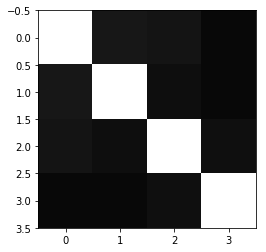

In [19]:
plt.imshow(np.mean(rmats, axis=0), vmin=0, vmax=1, cmap="gray")